In [4]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [10]:
!unzip santander-customer-satisfaction.zip

Archive:  santander-customer-satisfaction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [11]:
import pandas as pd

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [13]:
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(train_df.drop('TARGET', axis = 1),
                                                    train_df['TARGET'], test_size=0.33, random_state=42)
features_list = X_train.columns

## Строим и оцениваем простейшую линейную модель  

In [15]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from math import sqrt

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = features_list)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = features_list)

In [18]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [19]:
def print_classification_metrics(y_test, preds_test, preds_test_proba):
  print(f'ROC-AUC: {round(roc_auc_score(y_test, preds_test_proba), 2)}')
  print(f'Accuracy: {round(accuracy_score(y_test, preds_test), 2)}')
  print(f'Precision: {round(precision_score(y_test, preds_test), 2)}')
  print(f'Recall: {round(recall_score(y_test, preds_test), 3)}')

In [20]:
preds_test = model.predict(X_test_scaled)
preds_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print_classification_metrics(y_test, preds_test, preds_test_proba)

ROC-AUC: 0.78
Accuracy: 0.96
Precision: 0.12
Recall: 0.003


In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
len(features_list)

370

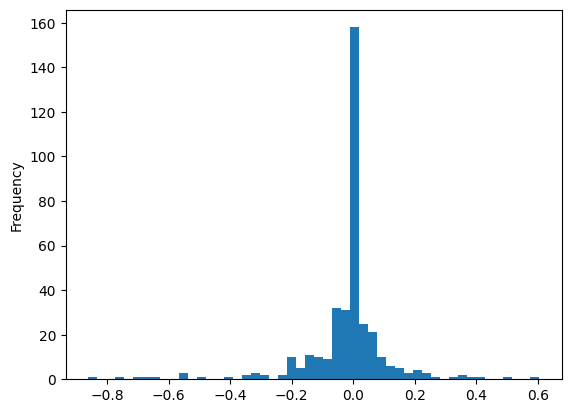

In [23]:
pd.Series(model.coef_[0,:], index=features_list).plot(kind='hist', bins = 50);

Имеем 370 признаков, из которых большинство около-нулевые.
Явно стоит провести отбор.

В лекциях говорилось о модуле Feature Selection, давайте поисседуем его:

### 1. Фильтры

In [24]:
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest

In [25]:
# Признаки с нулевой дисперсией (все значения одинаковые)

from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0)
sel.fit(X_train)

# Вытащить отобранные признаки:
non_zero_selected_features = sel.get_feature_names_out()
len(non_zero_selected_features)

315

In [26]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled[non_zero_selected_features], y_train)

preds_test = model.predict(X_test_scaled[non_zero_selected_features])
preds_test_proba = model.predict_proba(X_test_scaled[non_zero_selected_features])[:, 1]

print_classification_metrics(y_test, preds_test, preds_test_proba)

ROC-AUC: 0.78
Accuracy: 0.96
Precision: 0.12
Recall: 0.003


In [27]:
X_train_scaled = X_train_scaled[non_zero_selected_features]
X_test_scaled = X_test_scaled[non_zero_selected_features]

In [35]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(k = 10)
sel.fit(X_train[non_zero_selected_features], y_train)

selected_features = sel.get_feature_names_out()

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled[selected_features], y_train)

preds_test = model.predict(X_test_scaled[selected_features])
preds_test_proba = model.predict_proba(X_test_scaled[selected_features])[:, 1]

print_classification_metrics(y_test, preds_test, preds_test_proba)

ROC-AUC: 0.75
Accuracy: 0.96
Precision: 0.0
Recall: 0.0


In [ ]:
roc_auc_list = []

for i in range(1, 35):
  sel = SelectKBest(k = i)
  sel.fit(X_train[non_zero_selected_features], y_train)

  selected_features = sel.get_feature_names_out()

  model = LogisticRegression(solver='lbfgs', max_iter=1000)
  model.fit(X_train_scaled[selected_features], y_train)

  preds_test_proba = model.predict_proba(X_test_scaled[selected_features])[:, 1]

  roc_auc_list.append(roc_auc_score(y_test, preds_test_proba))

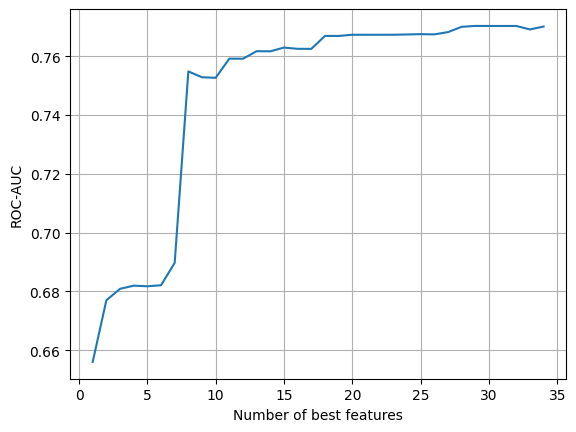

In [ ]:
pd.Series(roc_auc_list, index=np.arange(1, 35)).plot(grid = True, xlabel = 'Number of best features', ylabel = 'ROC-AUC');

In [ ]:
# Какой метод используется дефолтно? Что можно подставить ещё?

In [37]:
from sklearn.feature_selection import mutual_info_classif

In [38]:
sel = SelectKBest(score_func = mutual_info_classif, k = 10)
sel.fit(X_train[non_zero_selected_features], y_train)

selected_features = sel.get_feature_names_out()

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled[selected_features], y_train)

preds_test = model.predict(X_test_scaled[selected_features])
preds_test_proba = model.predict_proba(X_test_scaled[selected_features])[:, 1]

print_classification_metrics(y_test, preds_test, preds_test_proba)

ROC-AUC: 0.7
Accuracy: 0.96
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Обёртки

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

# работает очень долго!

model = LogisticRegression(solver='lbfgs', max_iter=10)
sfs = SequentialFeatureSelector(model, n_features_to_select=3)
sfs.fit(X_train, y_train)

## 3. Встроенные методы

In [46]:
from sklearn.feature_selection import SelectFromModel

In [55]:
from sklearn.ensemble import ExtraTreesClassifier

In [61]:
# На основе feature_importance:
model = LogisticRegression(solver='lbfgs', max_iter=10)
sel = SelectFromModel(model).fit(X_train, y_train)

sel.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['ID', 'saldo_var30', 'saldo_var42', 'delta_imp_amort_var34_1y3',
       'delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3',
       'delta_imp_aport_var33_1y3', 'delta_imp_compra_var44_1y3',
       'delta_imp_reemb_var13_1y3', 'delta_imp_reemb_var17_1y3',
       'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var17_out_1y3',
       'delta_imp_trasp_var33_in_1y3', 'delta_imp_venta_var44_1y3',
       'delta_num_aport_var13_1y3', 'delta_num_aport_var17_1y3',
       'delta_num_aport_var33_1y3', 'delta_num_compra_var44_1y3',
       'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3',
       'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3',
       'delta_num_trasp_var33_in_1y3', 'delta_num_venta_var44_1y3',
       'var38'], dtype=object)

In [71]:
# Вспоминаем что Ridge-регрессия зануляет веса:
from sklearn.linear_model import Ridge, Lasso

In [73]:
model = Ridge(alpha=1.0).fit(X_train, y_train)

In [74]:
feature_importances = pd.Series(model.coef_, index=X_train.columns)
feature_importances.head()

ID                         1.010103e-08
var3                       6.706653e-08
var15                      2.024989e-03
imp_ent_var16_ult1        -7.944111e-08
imp_op_var39_comer_ult1    6.353673e-06
dtype: float64

In [75]:
feature_importances[feature_importances == 0]

Series([], dtype: float64)

In [ ]:
# Что ж... Здесь не повезло

In [77]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000, verbose = False)
model.fit(X_train_scaled[non_zero_selected_features], y_train)

preds_test = model.predict(X_test_scaled[non_zero_selected_features])
preds_test_proba = model.predict_proba(X_test_scaled[non_zero_selected_features])[:, 1]

print_classification_metrics(y_test, preds_test, preds_test_proba)

In [ ]:
# У Catboost'а есть свой алгоритм отбора признаков: https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features

In [87]:
from google.colab import output
output.enable_custom_widget_manager()

In [88]:
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


feature_names = X_train.columns
train_pool = Pool(X_train, y_train, feature_names=list(X_train.columns))
test_pool = Pool(X_test, y_test, feature_names=list(X_test.columns))

model = CatBoostClassifier(iterations=1000, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-99',
    num_features_to_select=10,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: ignored

## Отбор признаков как часть пайплайна

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [ ]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("fs", SelectKBest(score_func=f_classif, k=20)),
])


# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, non_zero_selected_features)
])

# Создание конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", LogisticRegression())])

classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   array(['ID', 'var3', 'var15', 'imp_ent_var16_ult1',
       'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3',
       'imp_op_var40_comer_ult1', 'imp_op_v...
       'saldo_medio_var17_ult3', 'saldo_medio_var29_hace2',
       'saldo_medio_var29_ult1', 'saldo_medio_var29_ult3',
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38'],
      dtype=object))]))])),
                ('classifier', LogisticRegression())])

In [ ]:
classifier_pipline.fit(X_train[non_zero_selected_features], y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k='all'))]),
                                                                   array(['ID', 'var3', 'var15', 'imp_ent_var16_ult1',
       'imp_op_var39_comer_ult1', 'imp_op_var39_comer_ult3',
       'imp_op_var40_comer_ult1', 'imp_op_v...
       'saldo_medio_var17_ult3', 'saldo_medio_var29_hace2',
       'saldo_medio_var29_ult1', 'saldo_medio_var29_ult3',
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38'],
      dtype=object))]))])),
                ('classifier', LogisticRegression())])

In [ ]:
preds_test_proba = classifier_pipline.predict_proba(X_test_scaled[non_zero_selected_features])[:, 1]

roc_auc_score(y_test, preds_test_proba)

0.7277700918492194